In [16]:
import pandas as pd

match_id = '117093'
df_file_path = f'/home/atom/SoccerTrack-v2/data/interim/pitch_plane_coordinates/{match_id}/{match_id}_pitch_plane_coordinates.csv'
pitch_plane_df = pd.read_csv(df_file_path)

pitch_plane_df.head()

,frame,match_time,event_period,ball_status,id,x,y,teamId
0,251,0.0,FIRST_HALF,BALLOUT,170959,0.28,0.18,9701.0
1,251,0.0,FIRST_HALF,BALLOUT,170960,0.28,0.53,9701.0
2,251,0.0,FIRST_HALF,BALLOUT,170961,0.05,0.48,9701.0
3,251,0.0,FIRST_HALF,BALLOUT,172186,0.50,0.61,9701.0
4,251,0.0,FIRST_HALF,BALLOUT,176476,0.67,0.48,9834.0


In [24]:
from src.csv_utils import load_coordinates

pitch_plane_df = load_coordinates(df_file_path, match_id, 'FIRST_HALF')
pitch_plane_df.head()


2025-01-22 07:38:52.610 | INFO     | src.csv_utils:load_coordinates:41 - Loading coordinates from: /home/atom/SoccerTrack-v2/data/interim/pitch_plane_coordinates/117093/117093_pitch_plane_coordinates.csv
2025-01-22 07:38:53.358 | INFO     | src.csv_utils:load_coordinates:46 - Filtering coordinates for event period: FIRST_HALF


,frame,match_time,event_period,ball_status,id,x,y,teamId
0,0,0.0,FIRST_HALF,BALLOUT,170959,0.28,0.18,9701.0
1,0,0.0,FIRST_HALF,BALLOUT,170960,0.28,0.53,9701.0
2,0,0.0,FIRST_HALF,BALLOUT,170961,0.05,0.48,9701.0
3,0,0.0,FIRST_HALF,BALLOUT,172186,0.50,0.61,9701.0
4,0,0.0,FIRST_HALF,BALLOUT,176476,0.67,0.48,9834.0


In [82]:
import pandas as pd
import numpy as np

def remove_duplicates_and_linear_interpolate(
    df,
    group_col='id',
    frame_col='frame',
    interp_cols=('x', 'y'),
    period=30
):
    """
    For each group (by `group_col`), any row whose `frame` is NOT a multiple 
    of `period` has its `interp_cols` set to NaN. Then those NaNs are filled 
    by linear interpolation. The rest of the columns are left as-is.
    """
    # Make sure the DataFrame is sorted by group_col, then by frame_col
    df = df.sort_values(by=[group_col, frame_col]).copy()

    # Group by the chosen column (e.g., player or ball ID)
    grouped = df.groupby(group_col, as_index=False)

    def process_group(group):
        # Identify rows whose frame is a multiple of period
        mask = (group[frame_col] % period == 0)

        # Set values in x/y columns to NaN if not multiple of period
        for col in interp_cols:
            # Use .loc to avoid chained assignments
            group.loc[~mask, col] = np.nan

        # Now interpolate the NaNs in those columns
        group[list(interp_cols)] = group[list(interp_cols)].interpolate(method='linear')

        # Return the group as-is (no extra index renaming)
        return group

    # Apply the process to each group
    # `include_groups=False` avoids the deprecation warning in pandas >= 2.0
    result = grouped.apply(process_group, include_groups=True)

    # Reset the index from groupby/apply
    result.reset_index(drop=True, inplace=True)

    # Finally, sort by frame if desired
    result.sort_values(by=[frame_col], inplace=True)

    return result



/tmp/ipykernel_1100498/3993016069.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(process_group, include_groups=True)


,frame,match_time,event_period,ball_status,id,x,y,teamId
0,0,0.0,FIRST_HALF,BALLOUT,170959,0.280000,0.180000,9701.0
1,1,40.0,FIRST_HALF,BALLOUT,170959,0.280000,0.180000,9701.0
2,2,80.0,FIRST_HALF,BALLOUT,170959,0.280000,0.180000,9701.0
3,3,120.0,FIRST_HALF,BALLOUT,170959,0.280000,0.180000,9701.0
4,4,160.0,FIRST_HALF,BALLOUT,170959,0.280000,0.180000,9701.0
...,...,...,...,...,...,...,...,...
6995,6995,279800.0,FIRST_HALF,HOME,170959,0.238333,0.221667,9701.0
6996,6996,279840.0,FIRST_HALF,HOME,170959,0.240000,0.222000,9701.0
6997,6997,279880.0,FIRST_HALF,HOME,170959,0.241667,0.222333,9701.0
6998,6998,279920.0,FIRST_HALF,HOME,170959,0.243333,0.222667,9701.0


In [2]:
pitch_plane_first_frame = pitch_plane_df[(pitch_plane_df['frame'] == 251) & (pitch_plane_df['event_period'] == 'FIRST_HALF')].copy()
pitch_length = 105
pitch_width = 68
pitch_plane_first_frame.loc[:, 'x'] *= pitch_length
pitch_plane_first_frame.loc[:, 'y'] *= pitch_width

points = pitch_plane_first_frame[['x', 'y']].values

In [3]:
import cv2
import numpy as np

frame = cv2.imread(f'/home/atom/SoccerTrack-v2/data/interim/calibrated_videos/{match_id}/{match_id}_panorama.jpg')
H = np.load(f'/home/atom/SoccerTrack-v2/data/interim/homography/{match_id}/{match_id}_homography.npy')

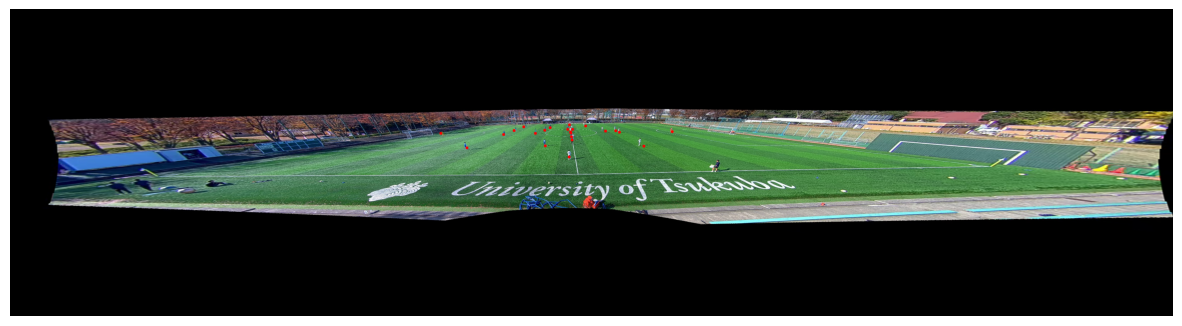

In [4]:
import matplotlib.pyplot as plt


# Reshape points for perspectiveTransform
points_reshaped = points.reshape(-1, 1, 2).astype(np.float32)

# Project the points onto the image using homography
projected_points = cv2.perspectiveTransform(points_reshaped, H)

# Create a copy of the frame to draw on
frame_with_points = frame.copy()

# Draw points on the image
for point in projected_points:
    x, y = point[0]
    cv2.circle(frame_with_points, (int(x), int(y)), 5, (0, 0, 255), -1)

# Save the image
cv2.imwrite('test.png', frame_with_points)

# Read the saved image
saved_image = cv2.imread('test.png')

# Display the image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(saved_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()